本程序：
1.通过电流峰值时刻的最大电场预测电压
2.通过电压预测流峰值时刻的最大电场

In [1]:
import time
import torch
import numpy as np
import deepxde as dde
import pandas as pd
import matplotlib.pyplot as plt
from deepxde.nn import activations
from deepxde.nn import initializers
from deepxde import config
from deepxde.nn.pytorch.nn import NN
from deepxde.nn.pytorch.fnn import FNN
from deepxde.data.data import Tuple
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import MinMaxScaler

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 'cuda' 这里如果没有指定具体的卡号,系统默认cuda:0
device = torch.device('cuda:0') 		# 使用2号卡
print(torch.cuda.get_device_name(0)) # 查看使用的设备名称

NVIDIA GeForce RTX 4090 D


In [3]:
class FNN(NN):
    """Fully-connected neural network."""

    def __init__(self, layer_sizes, activation, kernel_initializer, regularization=None ):
        super().__init__()
        if isinstance(activation, list):
            if not (len(layer_sizes) - 1) == len(activation):
                raise ValueError(
                    "Total number of activation functions do not match with sum of hidden layers and output layer!"
                )
            self.activation = list(map(activations.get, activation))
        else:
            self.activation = activations.get(activation)
        initializer = initializers.get(kernel_initializer)
        initializer_zero = initializers.get("zeros")
        
        self.regularizer = regularization  # =None
        
        self.linears = torch.nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(
                torch.nn.Linear(
                    layer_sizes[i - 1], layer_sizes[i], dtype=config.real(torch)
                )
            )
            initializer(self.linears[-1].weight)
            initializer_zero(self.linears[-1].bias)

    def forward(self, inputs):
        x = inputs
        if self._input_transform is not None:
            x = self._input_transform(x)
        for j, linear in enumerate(self.linears[:-1]):
            x = (
                self.activation[j](linear(x))
                if isinstance(self.activation, list)
                else self.activation(linear(x))
            )
        x = self.linears[-1](x)
        if self._output_transform is not None:
            x = self._output_transform(inputs, x)
        return x

In [4]:
#标准差
class DatasetsConstruct_MaxE2V:

    def for_train(self):
                
        E_train = pd.read_csv("F:\\DNNIPM4RF\\data\\E_train.csv",encoding='gbk', header=None)
        E_test = pd.read_csv("F:\\DNNIPM4RF\\data\\E_test.csv",encoding='gbk', header=None)
        voltage = pd.read_csv("F:\\DNNIPM4RF\\data\\voltage_train.csv",encoding='gbk', header=None)
        E_train_max = pd.read_csv("F:\\DNNIPM4RF\\data\\Max_E_train.csv",encoding='gbk', header=None)
        E_test_max = pd.read_csv("F:\\DNNIPM4RF\\data\\Max_E_test.csv",encoding='gbk', header=None)
        input_train = pd.read_csv("F:\\DNNIPM4RF\\data\\input_train.csv",encoding='gbk', header=None)
        
        MaxE_scaler = MinMaxScaler(feature_range=(0,1))
        voltage_scaler = MinMaxScaler(feature_range=(0,1))
        E_scaler = MinMaxScaler(feature_range=(0,1))
        VS_scaler = MinMaxScaler(feature_range=(0,1))  #voltage and electrode space
        
        E_train_max = MaxE_scaler.fit_transform(E_train_max)
        E_test_max = MaxE_scaler.transform(E_test_max)
        voltage = voltage_scaler.fit_transform(voltage)

        E_train = E_scaler.fit_transform(E_train)   
        E_test = E_scaler.transform(E_test)   
        input_train = VS_scaler.fit_transform(input_train)

        self.MaxE_scaler = MaxE_scaler
        self.voltage_scaler = voltage_scaler
        self.E_scaler = E_scaler
        self.VS_scaler = VS_scaler

        index = [i for i in range(len(E_train_max))]
        np.random.shuffle(index) 
        E_train_max= E_train_max[index]   
        E_test_max = E_test_max[index]
        voltage = voltage[index]

        index1 = [i for i in range(len(E_train))]
        np.random.shuffle(index1) 
        E_train= E_train[index1]
        E_test = E_test[index1]
        input_train = input_train[index1]

        data4MaxE2V = Tuple(E_train_max, voltage, E_test_max, voltage)
        data4V2E = Tuple(input_train, E_train, input_train, E_train)

        print("voltage:", voltage.shape)
        print("E_train_max:", E_train_max.shape)
        print("E_test_max:", E_test_max.shape)
        print("input_train:", input_train.shape)
        print("E_train:", E_train.shape)
        print("E_test:", E_test.shape)
        return data4MaxE2V, data4V2E


    def for_verify_integral(self, E_max_input=0, voltage_input=0):

        if E_max_input != 0:
            E_max_input = np.array([E_max_input],dtype='float32').reshape(-1, 1)
            E_max_input = self.MaxE_scaler.transform(E_max_input)
            y_pred = model_MaxE2V.predict(E_max_input)
            y_pred = self.voltage_scaler.inverse_transform(y_pred)
            print('预测电压为：', y_pred)

        if voltage_input != 0:
            self.num3 = str(voltage_input)
            num_validate = np.linspace(start=1, stop=200, num=200, dtype='float32').reshape(-1, 1)
            voltage_validate = np.full(200, voltage_input, dtype='float32').reshape(-1, 1) #与下面的voltage_validate用处不同
            input_train_validate = np.hstack((num_validate, voltage_validate))
            input_train_validate = self.VS_scaler.transform(input_train_validate)

            s_pred = model_V2E.predict(input_train_validate)
            s_pred = self.E_scaler.inverse_transform(s_pred)

            ax.plot(s_pred/1000,  linestyle="-",label=self.num3+"V Predicted")
            ax.legend(bbox_to_anchor=(0.75,0.2),loc='center',prop={'size':7},frameon=False)
            #plt.plot(num_validate.ravel(), s_pred.ravel())
            ax.set_xlabel("Electrode spacing (cm)")   
            ax.set_ylabel("Electric field (kV/cm)")
            ax.set_xticks([0, 41.67, 83.3, 125, 166.67, 200], labels=['0', '0.05', '0.10', '0.15', '0.20', '0.24'])
            ax.tick_params(top=True,bottom=True,left=True,right=True,direction='in')

In [5]:

dataset_MaxE2V = DatasetsConstruct_MaxE2V()
data4MaxE2V, data4V2E = dataset_MaxE2V.for_train()

voltage: (32, 1)
E_train_max: (32, 1)
E_test_max: (32, 1)
input_train: (6400, 2)
E_train: (6400, 1)
E_test: (6400, 1)


In [6]:
net_MaxE2V = FNN(
    [1,30, 30,30, 30,1],
    "gelu",
    "Glorot normal",
    regularization=["l2",1e-8]
)

In [7]:
net_V2E = FNN(
    [2,300, 300,300, 300,1],
    "gelu",
    "Glorot normal",
    regularization=["l2",1e-8]
)

In [8]:
model_MaxE2V = dde.Model(data4MaxE2V, net_MaxE2V)
model_MaxE2V.compile("adamw", lr=0.0005,decay=["step",500000,0.5], metrics=["mean l2 relative error"])
model_MaxE2V.restore('F:\\DNNIPM4RF\\model\\MaxE2V-298000.pt')

Compiling model...
'compile' took 0.550257 s



In [9]:
model_V2E = dde.Model(data4V2E, net_V2E)
model_V2E.compile("adamw", lr=0.0005,decay=["step",500000,0.5], metrics=["mean l2 relative error"])
model_V2E.restore('F:\\DNNIPM4RF\\model\\V2E-400000.pt')

Compiling model...
'compile' took 0.000438 s



In [10]:
verify_MaxE2V = dataset_MaxE2V.for_verify_integral( E_max_input=7300, voltage_input=0)

预测电压为： [[641.12335]]


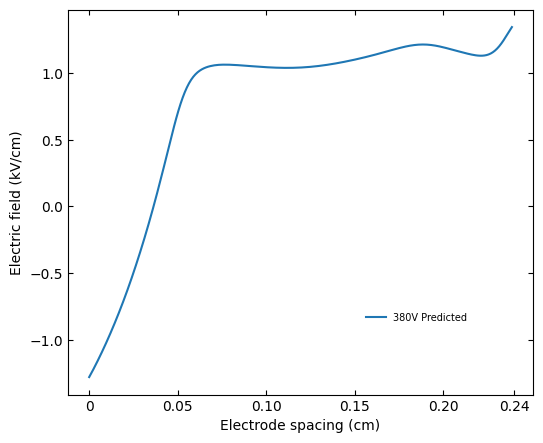

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
verify_MaxE2V = dataset_MaxE2V.for_verify_integral(E_max_input=0, voltage_input=380)